In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_curve, auc, average_precision_score, precision_recall_curve
)
from sklearn.feature_selection import RFE

In [2]:
df = pd.read_csv(r"C:\Downloads\archive\Drug.csv")  
print("Dataset shape:", df.shape)

Dataset shape: (200, 7)


In [3]:
print(df.head())

   Age Sex      BP Cholesterol        Na         K   Drug
0   23   F    HIGH        HIGH  0.792535  0.031258  drugY
1   47   M     LOW        HIGH  0.739309  0.056468  drugC
2   47   M     LOW        HIGH  0.697269  0.068944  drugC
3   28   F  NORMAL        HIGH  0.563682  0.072289  drugX
4   61   F     LOW        HIGH  0.559294  0.030998  drugY


In [4]:
df = df.drop_duplicates()
print("Missing values per column:\n", df.isnull().sum())

Missing values per column:
 Age            0
Sex            0
BP             0
Cholesterol    0
Na             0
K              0
Drug           0
dtype: int64


In [5]:
df = df.fillna(df.median(numeric_only=True))

In [6]:
label_encoders = {}
for col in ['Sex', 'BP', 'Cholesterol', 'Drug']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [7]:
X = df.drop("Drug", axis=1)
y = df["Drug"]

In [8]:
print("\n Target Value Counts:")
print(y.value_counts())


 Target Value Counts:
4    91
3    54
0    23
2    16
1    16
Name: Drug, dtype: int64


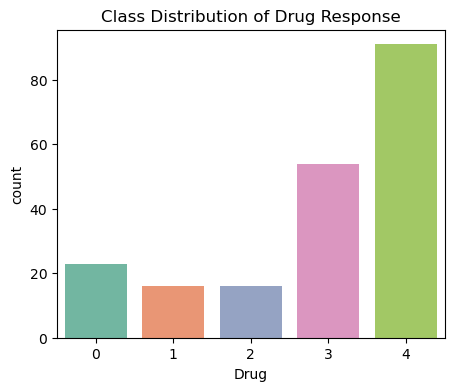

In [9]:
plt.figure(figsize=(5,4))
sns.countplot(x=y, palette="Set2")
plt.title("Class Distribution of Drug Response")
plt.show()

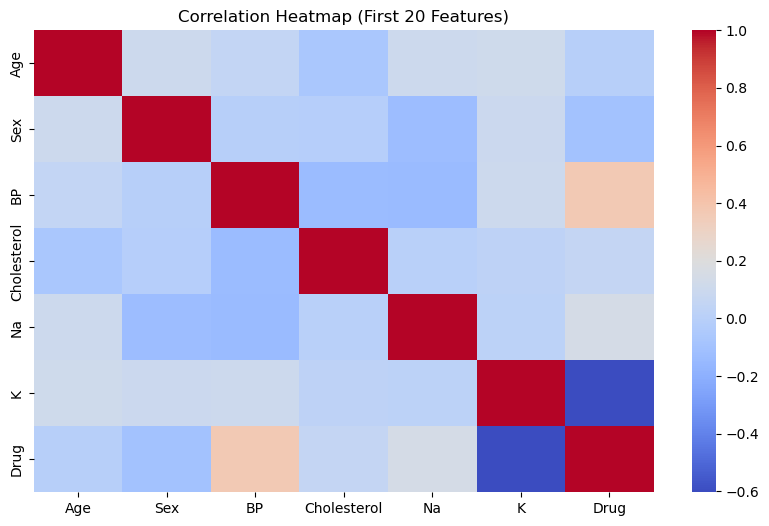

In [10]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True).iloc[:20,:20], cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap (First 20 Features)")
plt.show()

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
svm_linear = SVC(kernel="linear")
rfe = RFE(estimator=svm_linear, n_features_to_select=30)  
rfe.fit(X_train, y_train)

RFE(estimator=SVC(kernel='linear'), n_features_to_select=30)

In [14]:
selected_features = X.columns[rfe.support_]
print("\n Selected Top Features:", list(selected_features))


 Selected Top Features: ['Age', 'Sex', 'BP', 'Cholesterol', 'Na', 'K']


In [15]:
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

In [16]:
svm_clf = SVC(kernel="rbf", probability=True, random_state=42)
svm_clf.fit(X_train_rfe, y_train)

SVC(probability=True, random_state=42)

In [17]:
y_pred = svm_clf.predict(X_test_rfe)
print("Baseline SVM Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Baseline SVM Results:
Accuracy: 0.9
              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       1.00      1.00      1.00         3
           2       1.00      0.67      0.80         3
           3       1.00      0.82      0.90        11
           4       0.82      1.00      0.90        18

    accuracy                           0.90        40
   macro avg       0.96      0.86      0.90        40
weighted avg       0.92      0.90      0.90        40



In [18]:
param_grid = {
    "C": [0.1, 1, 10],
    "gamma": [0.01, 0.1, 1],
    "kernel": ["rbf", "linear"]
}

In [19]:
grid = GridSearchCV(SVC(probability=True, random_state=42), param_grid, cv=5, n_jobs=-1, verbose=1)
grid.fit(X_train_rfe, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=SVC(probability=True, random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1],
                         'kernel': ['rbf', 'linear']},
             verbose=1)

In [20]:
print("Best Parameters Found:", grid.best_params_)

Best Parameters Found: {'C': 1, 'gamma': 0.01, 'kernel': 'linear'}


In [21]:
best_svm = grid.best_estimator_
y_pred_best = best_svm.predict(X_test_rfe)

In [22]:
print("Optimized SVM Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))

Optimized SVM Results:
Accuracy: 0.95
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      0.82      0.90        11
           4       0.90      1.00      0.95        18

    accuracy                           0.95        40
   macro avg       0.98      0.96      0.97        40
weighted avg       0.96      0.95      0.95        40



In [23]:
cv_scores = cross_val_score(best_svm, X_train_rfe, y_train, cv=5)
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))

Cross-Validation Accuracy Scores: [0.96875 1.      0.9375  0.96875 1.     ]
Mean CV Accuracy: 0.975


In [24]:
classes = np.unique(y)
n_classes = len(classes)

In [25]:
y_test_bin = label_binarize(y_test, classes=classes)
y_proba = best_svm.predict_proba(X_test_rfe)

ROC-AUC Score: 1.0


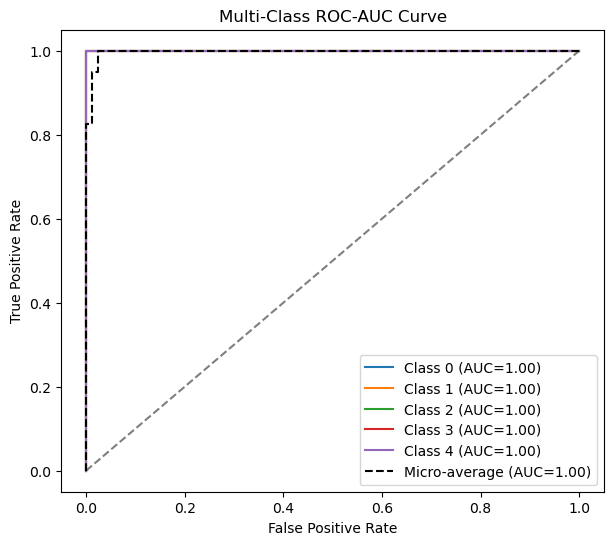

In [39]:
plt.figure(figsize=(7,6))
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {cls} (AUC={roc_auc:.2f})")
print("ROC-AUC Score:", roc_auc)
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_proba.ravel())
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color="black", linestyle="--", label=f"Micro-average (AUC={roc_auc:.2f})")
plt.plot([0,1],[0,1],"k--",alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC-AUC Curve")
plt.legend()
plt.show()

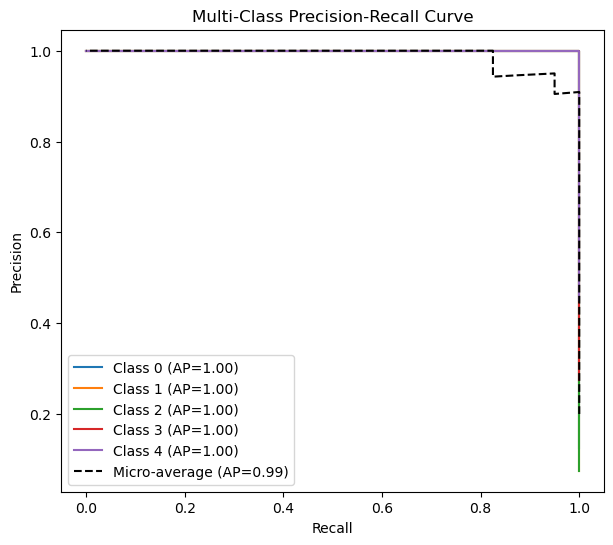

In [37]:
plt.figure(figsize=(7,6))                        
for i, cls in enumerate(classes):               
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i]) 
    ap = average_precision_score(y_test_bin[:, i], y_proba[:, i])                  
    plt.plot(recall, precision, label=f"Class {cls} (AP={ap:.2f})")                
precision, recall, _ = precision_recall_curve(y_test_bin.ravel(), y_proba.ravel()) 
ap = average_precision_score(y_test_bin, y_proba, average="micro")                  
plt.plot(recall, precision, color="black", linestyle="--", label=f"Micro-average (AP={ap:.2f})")  
plt.xlabel("Recall")                             
plt.ylabel("Precision")                          
plt.title("Multi-Class Precision-Recall Curve")  
plt.legend()                                      
plt.show()              

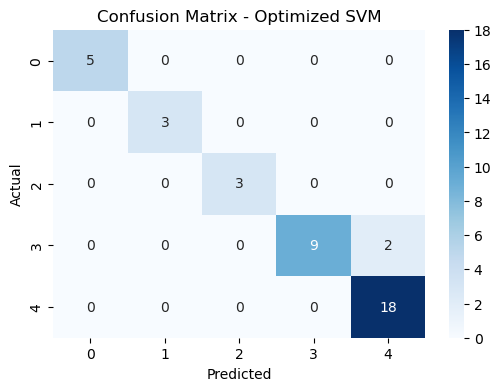

In [38]:
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Optimized SVM")
plt.show()